In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import tensorflow as tf
from dataclasses import dataclass
from datetime import timedelta
from helpers import helpers_functions
import joblib

In [2]:
df = pd.read_csv("datasets/tsla_data.csv")
df.sort_values("date", inplace=True)
df = df[["close","date"]]
df.head()

,close,date
1256,15.12,2019-08-19
1255,15.06,2019-08-20
1254,14.72,2019-08-21
1253,14.81,2019-08-22
1252,14.09,2019-08-23


In [3]:
@dataclass
class G:
    TIME = np.array(df["date"])
    SERIES = np.array(df["close"])
    WINDOW_SIZE = 1
    BATCH_SIZE = 16
    SHUFFLE_BUFFER_SIZE = 250

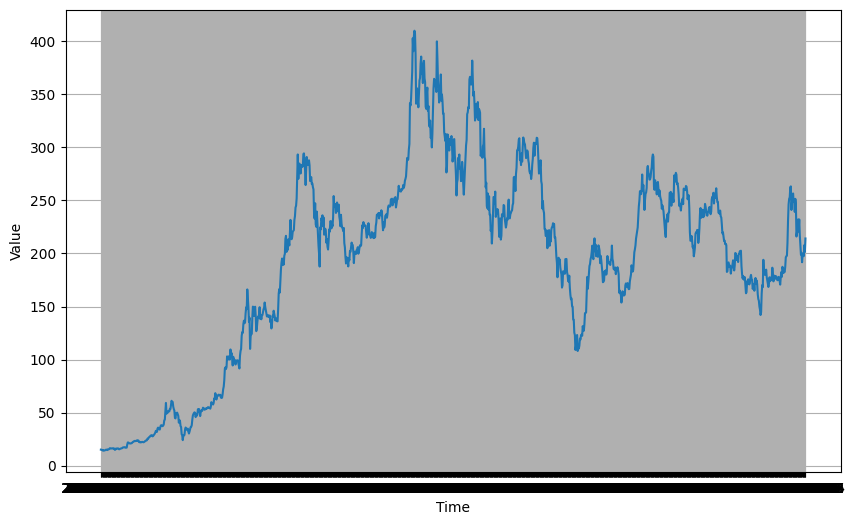

In [4]:
plt.figure(figsize=(10, 6))
helpers_functions.plot_series(G.TIME, G.SERIES)
plt.show()

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

data = windowed_dataset(G.SERIES, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [6]:
def create_uncompiled_model():

    model = tf.keras.models.Sequential(
        [tf.keras.layers.LSTM(64, activation="relu", input_shape=[None,1]),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1)]
    )

    return model

In [7]:
uncompiled_model = create_uncompiled_model()

for X, y in data.take(1):

    print(f"Testing model prediction with input of shape {X.shape}...")
    y_pred = uncompiled_model.predict(X)

y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f"Squuezed predicted y shape = {y_pred_shape}"
                                 f"whereas actual y shape = {y.shape}.")

print("Your current architecture is compatible with the windowed dataset!")

c:\Users\MEHMET\Desktop\stock_forecast\stenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Testing model prediction with input of shape (16, 1)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Your current architecture is compatible with the windowed dataset!


In [8]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = tf.keras.backend.get_value(self.model.optimizer.learning_rate)

In [9]:
def adjust_learning_rate(dataset):
    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    lr_logger = LearningRateLogger()

    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule, lr_logger])

    return history

In [10]:
lr_history = adjust_learning_rate(data)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step - loss: 66.6756 - mae: 67.1732 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 7.4928 - mae: 7.9782 - learning_rate: 1.1220e-04 - lr: 1.1220e-04
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 10.6939 - mae: 11.1749 - learning_rate: 1.2589e-04 - lr: 1.2589e-04


C:\Users\MEHMET\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 10.4055 - mae: 10.8828 - learning_rate: 1.4125e-04 - lr: 1.4125e-04
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 6.9537 - mae: 7.4274 - learning_rate: 1.5849e-04 - lr: 1.5849e-04
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 12.8503 - mae: 13.3390 - learning_rate: 1.7783e-04 - lr: 1.7783e-04
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 10.6897 - mae: 11.1753 - learning_rate: 1.9953e-04 - lr: 1.9953e-04
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 11.1835 - mae: 11.6657 - learning_rate: 2.2387e-04 - lr: 2.2387e-04
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 20.2410 - mae: 20.7329 - learning_rate: 2.5119e-04 - lr: 2.5119e-04
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 17.1761 - mae: 17.6458 - learning_rate: 2.8184e-04 - lr: 2.8184e-04
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 19.3795 - mae: 19.8654 - learning_ra

In [11]:
def get_best_learning_rate(history):

    losses = history.history['loss']
    

    min_loss_epoch = losses.index(min(losses))
    

    best_lr = 1e-4 * 10**(min_loss_epoch / 20)
    
    return best_lr

In [12]:
best_lr = get_best_learning_rate(lr_history)

In [13]:
print(best_lr)

0.00011220184543019634


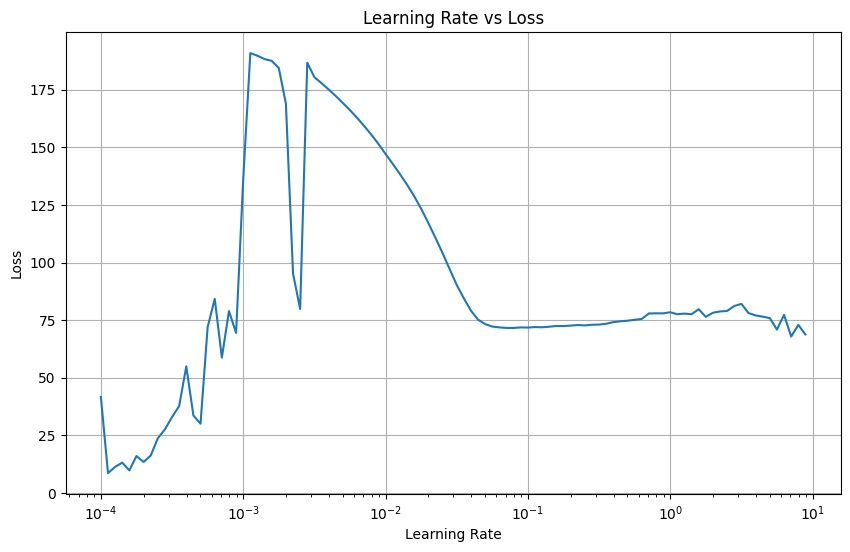

In [14]:
plt.figure(figsize=(10, 6))
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs Loss')
plt.grid(True)
plt.show()

In [15]:
def create_model():

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
                  metrics=["mean_absolute_error"])
    
    return model

In [16]:
model = create_model()


history = model.fit(data, epochs=50)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step - loss: 150.6611 - mean_absolute_error: 151.1611
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 147.4797 - mean_absolute_error: 147.9797
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 140.4801 - mean_absolute_error: 140.9801
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 128.7610 - mean_absolute_error: 129.2610
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 118.0279 - mean_absolute_error: 118.5279
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 97.1906 - mean_absolute_error: 97.6906
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 75.0209 - mean_absolute_error: 75.5209
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 37.9188 - mean_absolute_error: 38.4188
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 7.6974 - mean_absolute_error: 8.1887
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 5.3758 - mean_absolute_error: 5.8609
Ep

In [17]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [18]:
# Compute the forecast for all the series
lstm_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [19]:
lstm_forecast.shape

(1257,)

In [20]:
df["lstm_forecast"] = lstm_forecast

In [21]:
df.set_index("date", inplace=True)

In [22]:
df

,close,lstm_forecast
date,,
2019-08-19,15.12,15.017235
2019-08-20,15.06,14.953199
2019-08-21,14.72,14.590114
2019-08-22,14.81,14.686257
2019-08-23,14.09,13.916539
...,...,...
2024-08-09,200.00,200.672699
2024-08-12,197.49,198.182587
2024-08-13,207.83,208.437973


In [23]:
train, valid = helpers_functions.train_split(df)

In [24]:
lags = np.arange(1,6)

In [25]:
train = helpers_functions.lag_features(train, lags,"close")

c:\Users\MEHMET\Desktop\stock_forecast\helpers\helpers_functions.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, f"lag_{i}"] = dataframe[target].shift(i)
c:\Users\MEHMET\Desktop\stock_forecast\helpers\helpers_functions.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, f"lag_{i}"] = dataframe[target].shift(i)
c:\Users\MEHMET\Desktop\stock_forecast\helpers\helpers_functions.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [26]:
valid = helpers_functions.lag_features(valid, lags, "close")

c:\Users\MEHMET\Desktop\stock_forecast\helpers\helpers_functions.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, f"lag_{i}"] = dataframe[target].shift(i)
c:\Users\MEHMET\Desktop\stock_forecast\helpers\helpers_functions.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, f"lag_{i}"] = dataframe[target].shift(i)
c:\Users\MEHMET\Desktop\stock_forecast\helpers\helpers_functions.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [27]:
train_X = train.drop(columns="close")
train_y = train["close"]

valid_X = valid.drop(columns="close")
valid_y = valid["close"]

In [28]:
lgbm_model = LGBMRegressor()

lgbm_model.fit(train_X,train_y)

pred_y = lgbm_model.predict(valid_X)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1005, number of used features: 6
[LightGBM] [Info] Start training from score 188.337691


In [29]:
print(mean_absolute_error(valid_y,pred_y))

0.43612619908760386


In [30]:
print(mean_squared_error(valid_y,pred_y))

0.8059305565905609


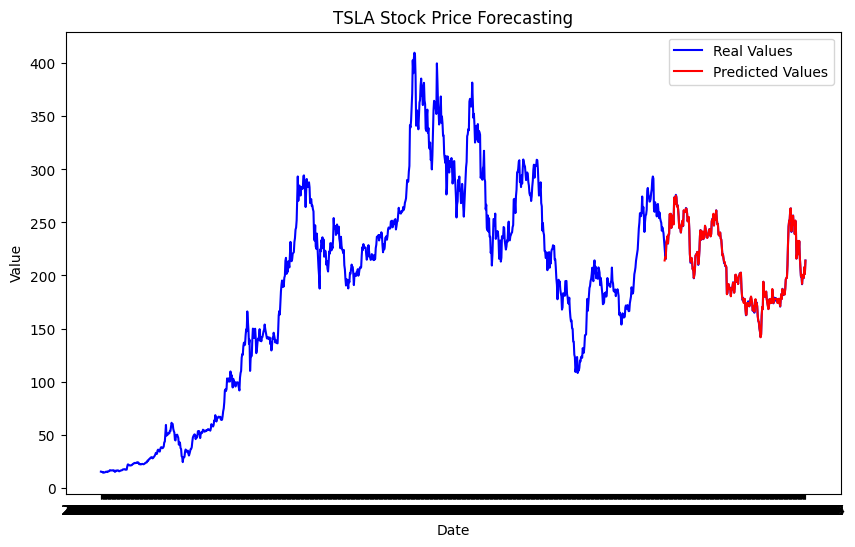

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['close'], label='Real Values', color='blue')
plt.plot(valid_X.index, pred_y, label='Predicted Values', color='red')
plt.title('TSLA Stock Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [32]:
start_date = df.index.max()

In [33]:
X_last = valid_X.iloc[-1:]

In [34]:
X_last

,lstm_forecast,lag_1,lag_2,lag_3,lag_4,lag_5
date,,,,,,
2024-08-15,214.693359,201.38,207.83,197.49,200.0,198.84


In [35]:
future_dates, predictions = helpers_functions.predict_future(lgbm_model, X_last, start_date)

In [36]:
future_dates

[Timestamp('2024-08-16 00:00:00'),
 Timestamp('2024-08-17 00:00:00'),
 Timestamp('2024-08-18 00:00:00'),
 Timestamp('2024-08-19 00:00:00'),
 Timestamp('2024-08-20 00:00:00'),
 Timestamp('2024-08-21 00:00:00'),
 Timestamp('2024-08-22 00:00:00'),
 Timestamp('2024-08-23 00:00:00'),
 Timestamp('2024-08-24 00:00:00'),
 Timestamp('2024-08-25 00:00:00'),
 Timestamp('2024-08-26 00:00:00'),
 Timestamp('2024-08-27 00:00:00'),
 Timestamp('2024-08-28 00:00:00'),
 Timestamp('2024-08-29 00:00:00'),
 Timestamp('2024-08-30 00:00:00'),
 Timestamp('2024-08-31 00:00:00'),
 Timestamp('2024-09-01 00:00:00'),
 Timestamp('2024-09-02 00:00:00'),
 Timestamp('2024-09-03 00:00:00'),
 Timestamp('2024-09-04 00:00:00'),
 Timestamp('2024-09-05 00:00:00'),
 Timestamp('2024-09-06 00:00:00'),
 Timestamp('2024-09-07 00:00:00'),
 Timestamp('2024-09-08 00:00:00'),
 Timestamp('2024-09-09 00:00:00'),
 Timestamp('2024-09-10 00:00:00'),
 Timestamp('2024-09-11 00:00:00'),
 Timestamp('2024-09-12 00:00:00'),
 Timestamp('2024-09-

In [37]:
predictions

[213.9529766303257,
 212.95629086117427,
 213.13499022976265,
 213.0232780087731,
 213.04359558987292,
 213.05128958426442,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369,
 213.0767940454369]

In [38]:
valid_X.to_csv("datasets/lstm_lgbm_val_x.csv")
valid_y.to_csv("datasets/lstm_lgbm_val_y.csv")


In [39]:
joblib.dump(lgbm_model, "lgmb_lstm.pkl")

['lgmb_lstm.pkl']